<a href="https://colab.research.google.com/github/AndrewsVieira/tcc_analise_comparativa_machine_learning/blob/main/AnaliseComparativaMLTurbofan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 --version
!pip3 list

Python 3.8.16
Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh                       

##1 Machine learning

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from google.colab import drive
from pandas.core.algorithms import value_counts_arraylike
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate



root = '/content/drive'
drive.mount(root, force_remount=True)

dir_path = "{}/MyDrive/SENAI/TCC/Dataset/Turbofan/".format(root)

index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

def add_remaining_useful_life(df):
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('RUL')
    plt.show()

drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors
X_train = train.drop(drop_labels, axis=1)
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

def display_scores(scores, score_name = None):
  if score_name != None:
    scores_name = 'Scores for ' + score_name + ':'
    Mean_name = 'Mean for ' + score_name + ':'
    sd_name = 'Standard deviation for ' + score_name + ':'
  else:
    scores_name = 'Scores:'
    Mean_name = 'Mean:'
    sd_name = 'Standard deviation:'
  print(scores_name, scores)
  print(Mean_name, scores.mean())
  print(sd_name, scores.std())

def normalize(dataset):
  for column in dataset:
    dataset[column] = (dataset[column] - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

normalize(X_train)

def get_error_values(y, y_hat):
  r = [];
  for i in range(len(y)):
    x = y[i] - y_hat[i]
    x = x**2
    x = np.sqrt(x)
    r.append(x)
  return r

def get_values_motors(dataset, boolExpression):
  values = []
  for i in range(0, len(dataset)):
    if(boolExpression):
      value = dataset[i]
      values.append(value)
  return values;

def evaluate(model, dataset_x_train, dataset_y_train):
  scores = cross_validate(model, dataset_x_train, dataset_y_train, groups=None, scoring="neg_mean_squared_error", cv=5, n_jobs=5, return_train_score=True, return_estimator=True, error_score=1)
  rmse_score = np.sqrt(-scores['train_score'])
  display_scores(rmse_score, 'train')
  rmse_score = np.sqrt(-scores['test_score'])
  display_scores(rmse_score, 'test')

def evaluate_rmse(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

def rmse(y_true, y_hat):
  mse = mean_squared_error(y_true, y_hat)
  return np.sqrt(mse)

def r2(y_true, y_hat):
  return r2_score(y_true, y_hat)

Mounted at /content/drive


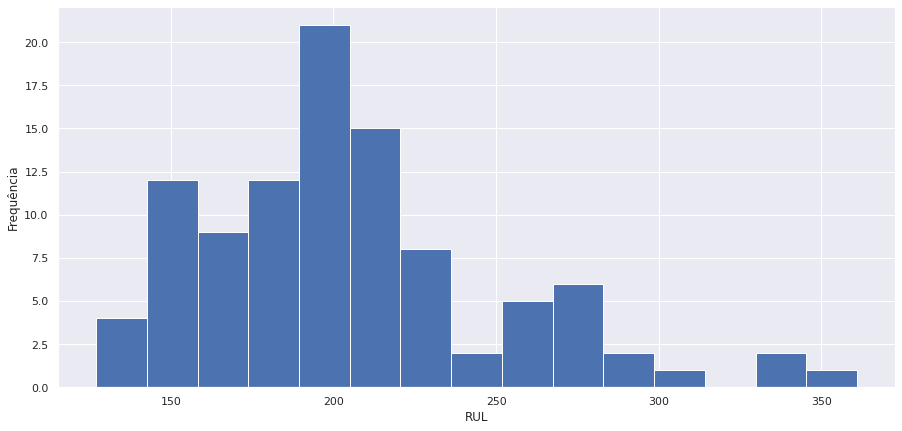

In [ ]:
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('Frequência')
plt.show()

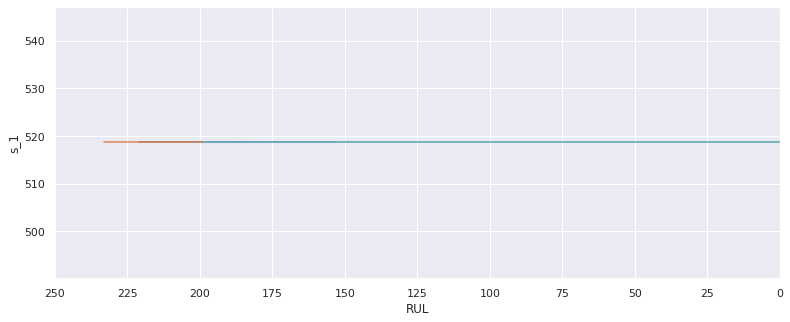

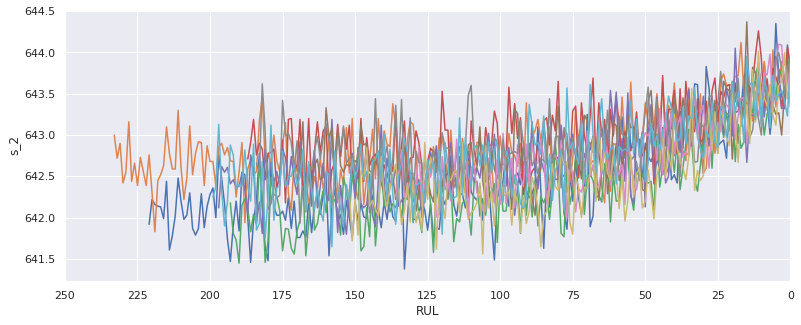

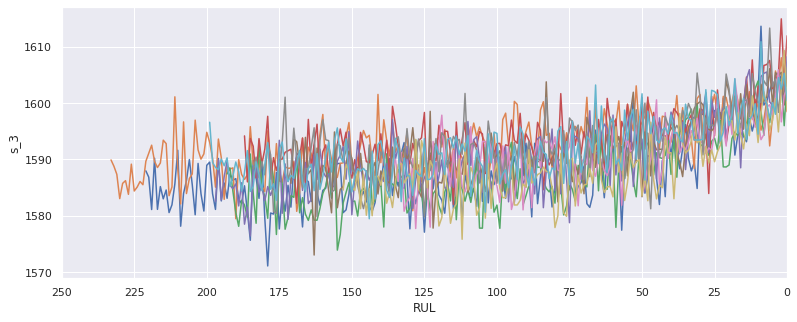

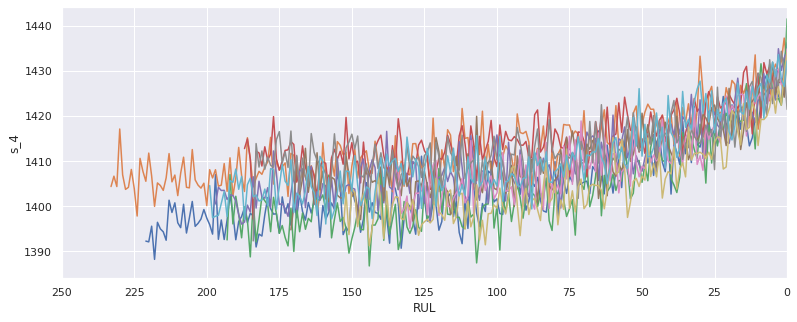

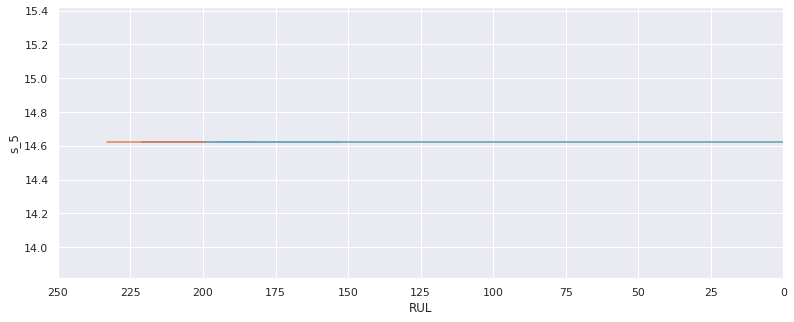

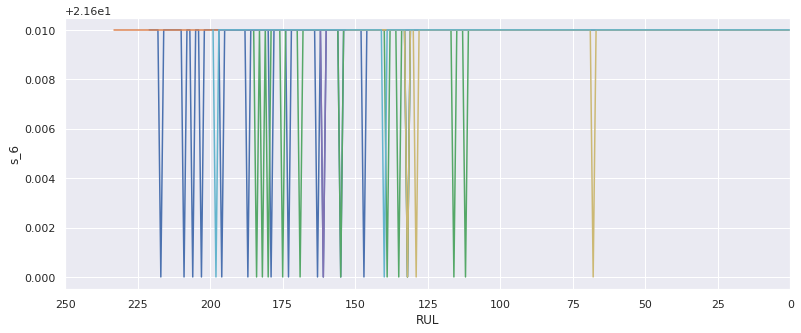

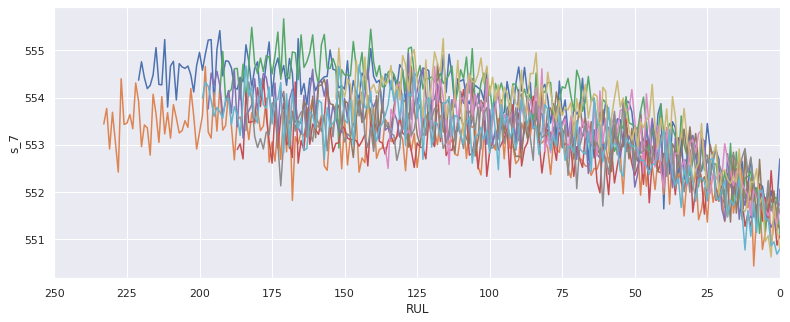

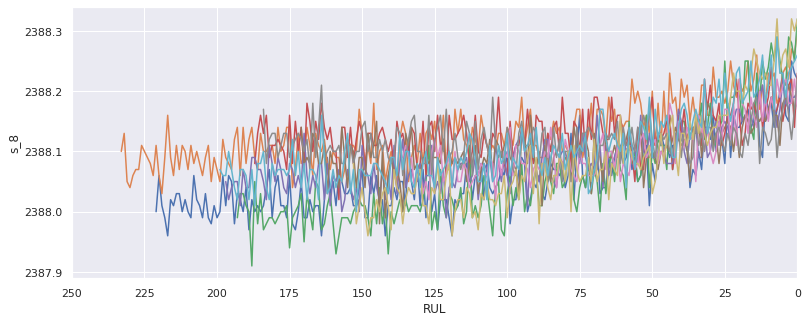

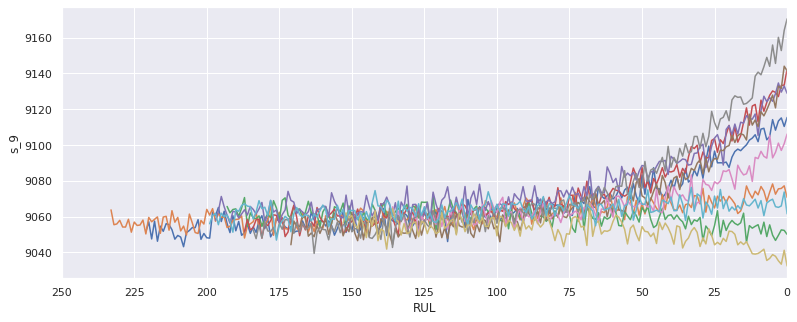

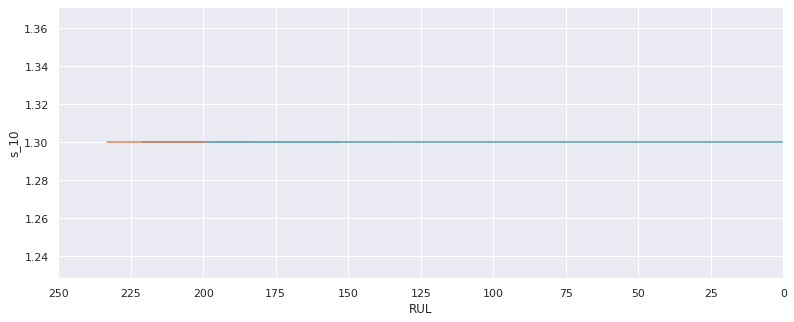

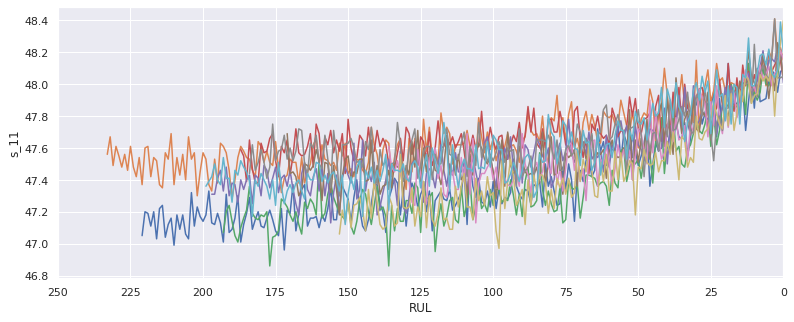

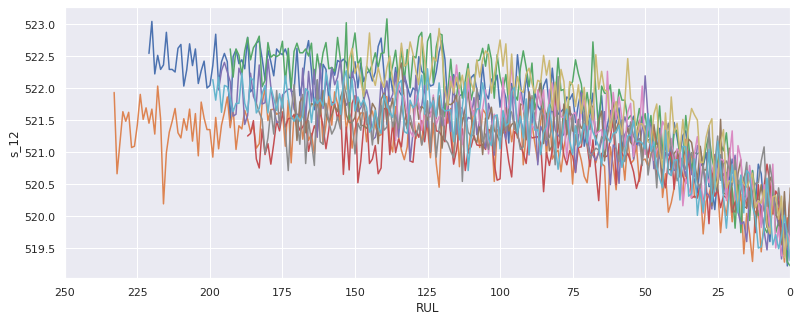

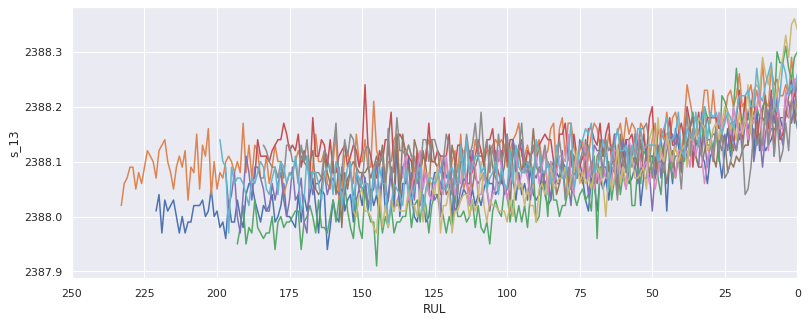

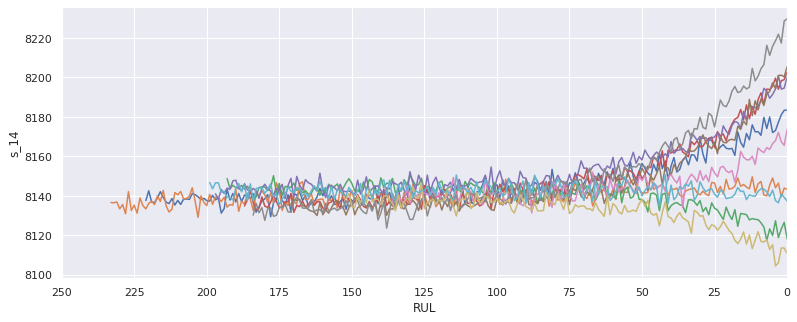

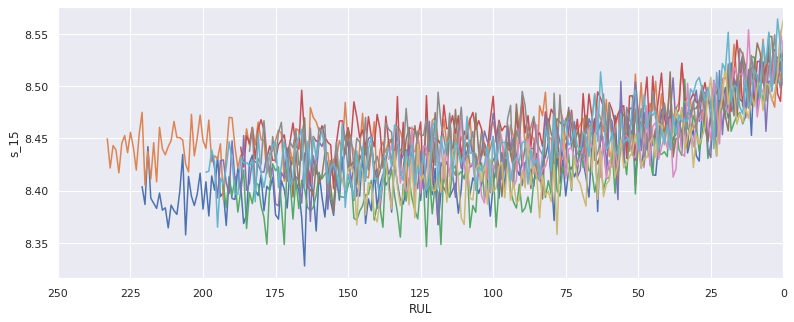

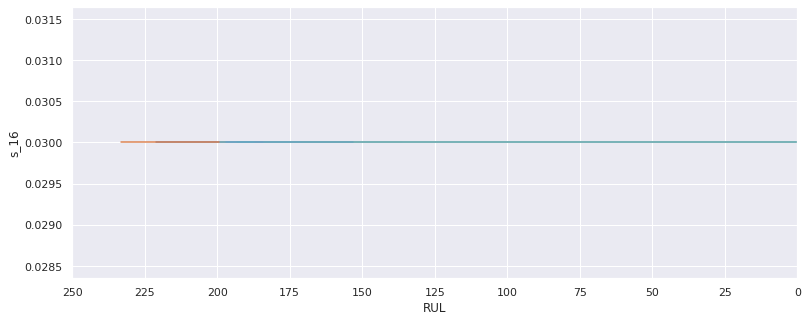

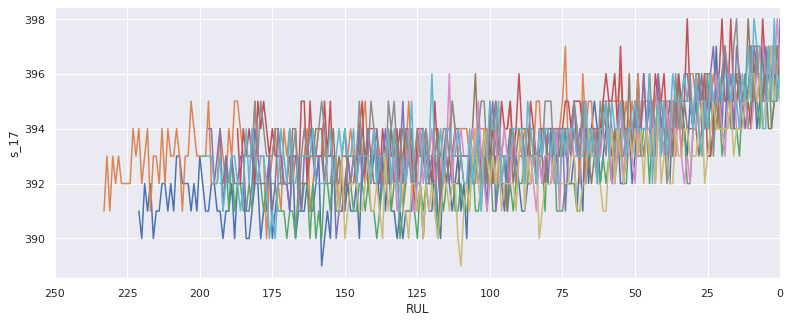

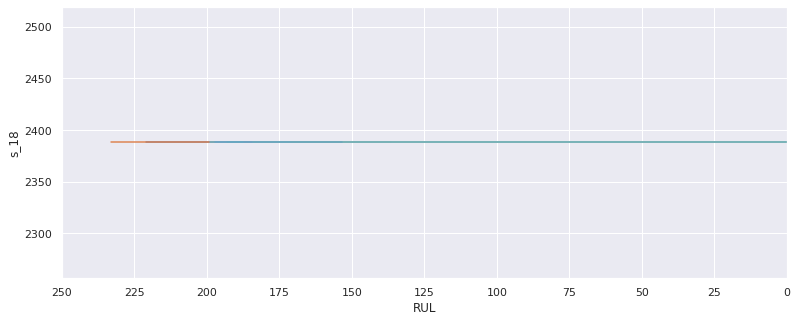

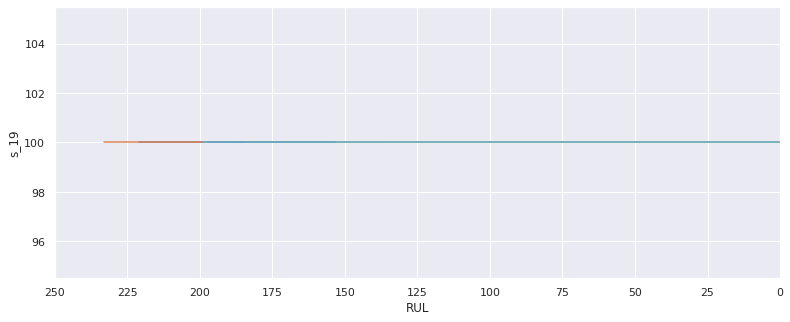

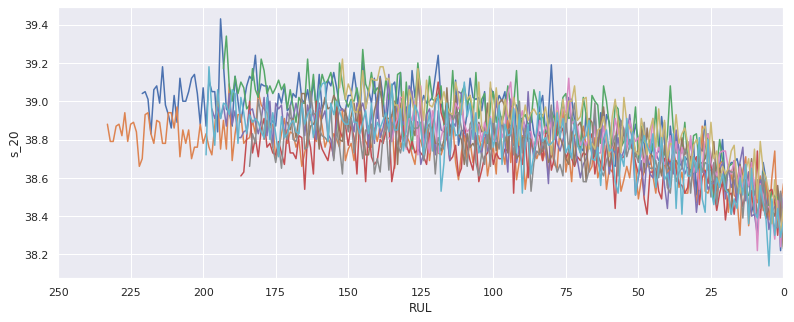

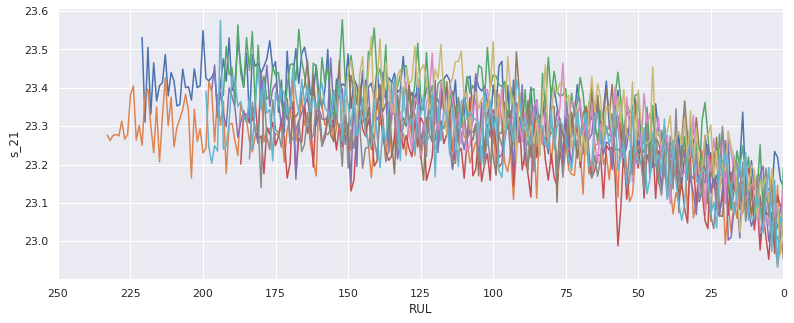

In [ ]:
for i in test[sensor_names]:
  plot_sensor(i)

##2 Modelos

###Regressão linear

In [ ]:
from sklearn.linear_model import LinearRegression
# create and fit model
lin_reg = LinearRegression()

In [ ]:
scores = cross_validate(lin_reg, X_train, y_train, groups=None, scoring="neg_mean_squared_error", cv=5, n_jobs=5, return_train_score=True, return_estimator=True, error_score=1)
rmse_score = np.sqrt(-scores['train_score'])
display_scores(rmse_score, 'train')
rmse_score = np.sqrt(-scores['test_score'])
display_scores(rmse_score, 'test')

Scores for train: [46.17397292 46.64112407 45.48332318 42.48401651 41.9998409 ]
Mean for train: 44.55645551703991
Standard deviation for train: 1.9314539056716635
Scores for test: [38.15881075 36.10088945 41.64097056 52.91203435 54.45062703]
Mean for test: 44.652666429459074
Standard deviation for test: 7.597243626798437


In [ ]:
from sklearn.model_selection import cross_val_predict
predicts_lin_reg = cross_val_predict(lin_reg, X_test, y_test, cv = 5)

####Gráfico de dispersão

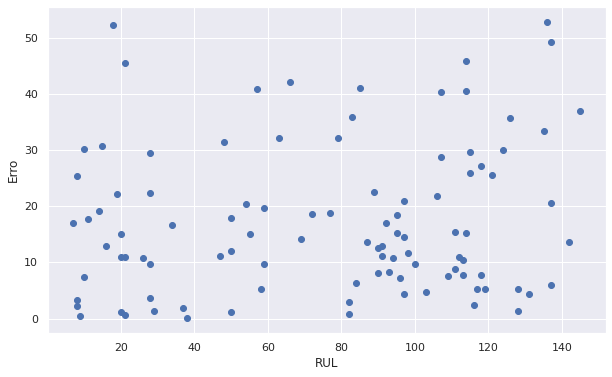

In [ ]:
y = get_values_motors(y_test['RUL'].values, True)
y_hat = get_values_motors(pd.DataFrame(predicts_lin_reg, columns=['RUL'])['RUL'].values, True)

rt = pd.DataFrame({
    'y': y,
    'y_hat': y_hat
})
rt['error'] = np.sqrt((rt['y'] - rt['y_hat'])**2)

plt.figure(figsize=(10,6))
plt.scatter(rt['y'], rt['error'])
plt.xlabel("RUL")
plt.ylabel("Erro")
plt.grid(True)
plt.show()


####Histograma comparativo

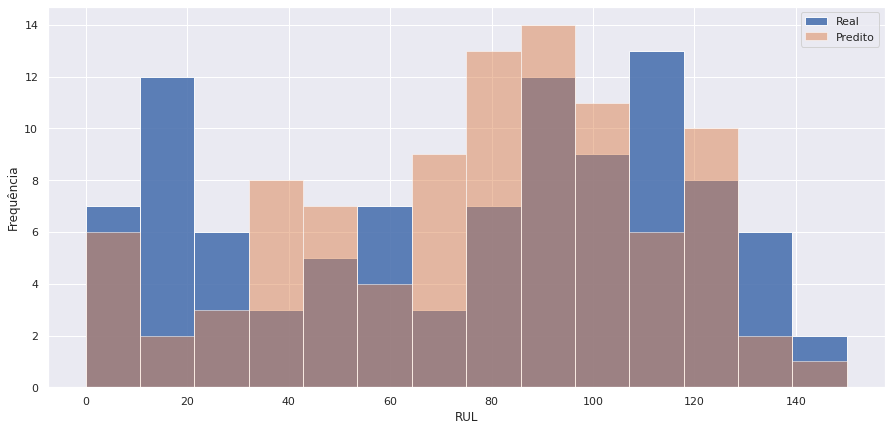

In [ ]:
bins = np.linspace(0, 150, 15)
plt.figure(figsize=(15,7)) 
plt.hist(rt['y'], bins, alpha=0.9, label='Real')
plt.hist(rt['y_hat'], bins, alpha=0.5, label='Predito')
plt.xlabel('RUL')
plt.ylabel('Frequência')
plt.legend()
plt.show()

###Árvore de decisão

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=4)

In [ ]:
scores = cross_validate(tree_reg, X_train, y_train, groups=None, scoring="neg_mean_squared_error", cv=5, n_jobs=5, return_train_score=True, return_estimator=True, error_score=1)
rmse_score = np.sqrt(-scores['train_score'])
display_scores(rmse_score, 'train')
rmse_score = np.sqrt(-scores['test_score'])
display_scores(rmse_score, 'test')

Scores for train: [47.00099686 46.98076789 46.07969473 43.20164825 42.56765405]
Mean for train: 45.16615235573097
Standard deviation for train: 1.9029195149188267
Scores for test: [38.97002145 39.2370892  41.43244701 53.68707208 56.33307727]
Mean for test: 45.931941402923314
Standard deviation for test: 7.5081356472908025


In [ ]:
from sklearn.model_selection import cross_val_predict
predicts_tree_reg = cross_val_predict(tree_reg, X_test, y_test, cv = 5)

####Gráfico de dispersão

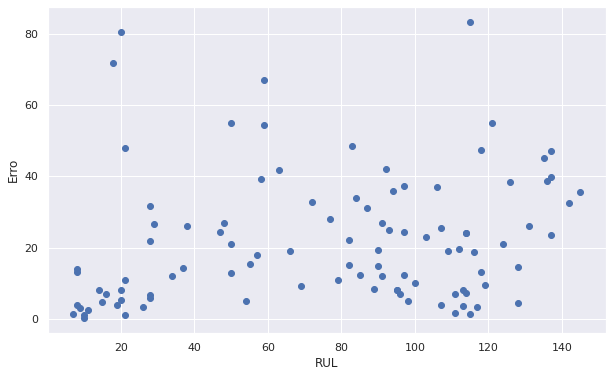

In [ ]:
y = get_values_motors(y_test['RUL'].values, True)
y_hat = get_values_motors(pd.DataFrame(predicts_tree_reg, columns=['RUL'])['RUL'].values, True)

rt = pd.DataFrame({
    'y': y,
    'y_hat': y_hat
})
rt['error'] = np.sqrt((rt['y'] - rt['y_hat'])**2)

plt.figure(figsize=(10,6))
plt.scatter(rt['y'], rt['error'])
plt.xlabel("RUL")
plt.ylabel("Erro")
plt.grid(True)
plt.show()


####Histograma comparativo

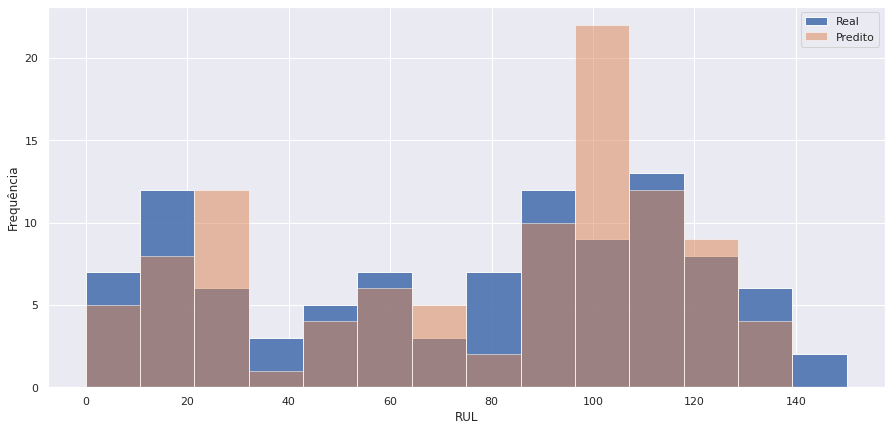

In [ ]:
bins = np.linspace(0, 150, 15)
plt.figure(figsize=(15,7)) 
plt.hist(rt['y'], bins, alpha=0.9, label='Real')
plt.hist(rt['y_hat'], bins, alpha=0.5, label='Predito')
plt.xlabel('RUL')
plt.ylabel('Frequência')
plt.legend()
plt.show()

###Florestas aleatórias

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

####RandomizedSearch

In [ ]:
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import truncnorm
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
  'n_estimators': randint(4,200), 
  'max_features': truncnorm(a=0,b=1,loc=0.25,scale=0.1),
  'min_samples_split': uniform(0.01, 0.199)
}
grid_search = RandomizedSearchCV(forest_reg, param_grid, n_iter=100, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
grid_search.best_params_


{'max_features': 0.34463189720441234,
 'min_samples_split': 0.012015962066134674,
 'n_estimators': 42}

In [ ]:
best_RandomForestRegressor = grid_search.best_estimator_

In [ ]:
print(best_RandomForestRegressor)

RandomForestRegressor(max_features=0.34463189720441234,
                      min_samples_split=0.012015962066134674, n_estimators=42)


In [ ]:
forest_reg_with_randomized_search = RandomForestRegressor(max_features=0.33283600344370706,
                      min_samples_split=0.01266401590507004, n_estimators=176)
scores = cross_validate(forest_reg_with_randomized_search, X_train, y_train, groups=None, scoring="neg_mean_squared_error", cv=5, n_jobs=5, return_train_score=True, return_estimator=True, error_score=1)
rmse_score = np.sqrt(-scores['train_score'])
display_scores(rmse_score, 'train')
rmse_score = np.sqrt(-scores['test_score'])
display_scores(rmse_score, 'test')

Scores for train: [41.20638778 41.35367391 40.65512605 37.28635001 37.01306343]
Mean for train: 39.50292023778984
Standard deviation for train: 1.937381715946626
Scores for test: [35.50707189 34.50898681 37.75009005 51.78041523 52.61411985]
Mean for test: 42.432136764768124
Standard deviation for test: 8.046334319359561


In [ ]:
from sklearn.model_selection import cross_val_predict
predicts_forest_reg_with_randomized_search = cross_val_predict(forest_reg_with_randomized_search, X_test, y_test, cv = 5)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed whe

####Gráfico de dispersão

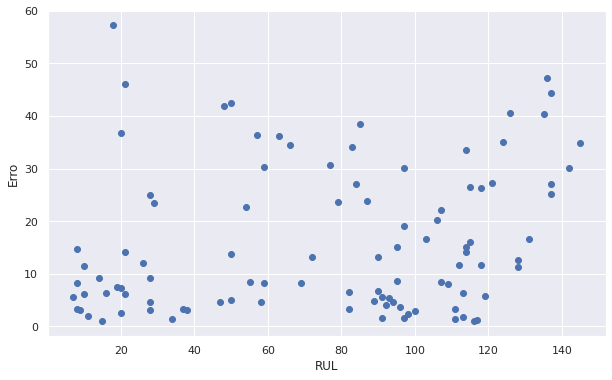

In [ ]:
y = get_values_motors(y_test['RUL'].values, True)
y_hat = get_values_motors(pd.DataFrame(predicts_forest_reg_with_randomized_search, columns=['RUL'])['RUL'].values, True)

rt = pd.DataFrame({
    'y': y,
    'y_hat': y_hat
})
rt['error'] = np.sqrt((rt['y'] - rt['y_hat'])**2)

plt.figure(figsize=(10,6))
plt.scatter(rt['y'], rt['error'])
plt.xlabel("RUL")
plt.ylabel("Erro")
plt.grid(True)
plt.show()


####Histograma comparativo

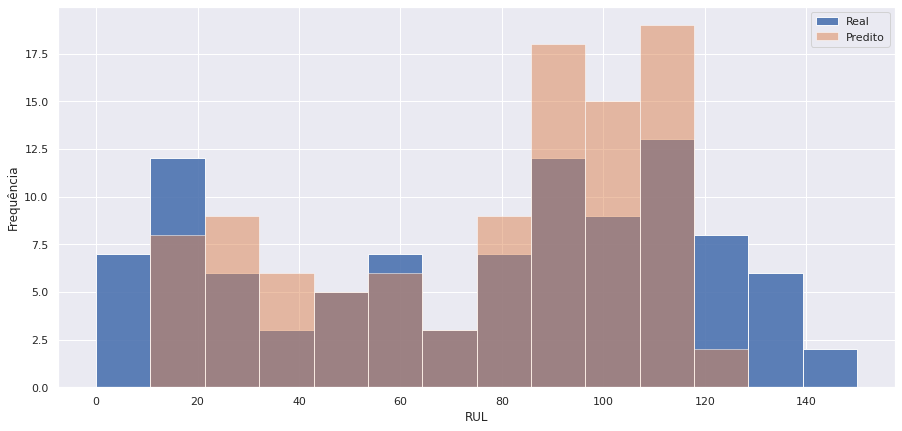

In [ ]:
bins = np.linspace(0, 150, 15)
plt.figure(figsize=(15,7)) 
plt.hist(rt['y'], bins, alpha=0.9, label='Real')
plt.hist(rt['y_hat'], bins, alpha=0.5, label='Predito')
plt.xlabel('RUL')
plt.ylabel('Frequência')
plt.legend()
plt.show()

###SVR Linear

In [ ]:
from sklearn.svm import SVR
svr = SVR(kernel='linear')
scores = cross_validate(svr, X_train, y_train, groups=None, scoring="neg_mean_squared_error", cv=5, n_jobs=5, return_train_score=True, return_estimator=True, error_score=1)
rmse_score = np.sqrt(-scores['train_score'])
display_scores(rmse_score, 'train')
rmse_score = np.sqrt(-scores['test_score'])
display_scores(rmse_score, 'test')

Scores for train: [47.30578543 47.65244863 46.50232874 43.40301372 42.84212667]
Mean for train: 45.54114064021939
Standard deviation for train: 2.017510266183517
Scores for test: [38.14154754 34.20934606 40.16791297 55.80883866 57.20979252]
Mean for test: 45.10748754827902
Standard deviation for test: 9.515018719873941


In [ ]:
from sklearn.model_selection import cross_val_predict
predicts_svr = cross_val_predict(svr, X_test, y_test, cv = 5)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

####Gráfico de dispersão

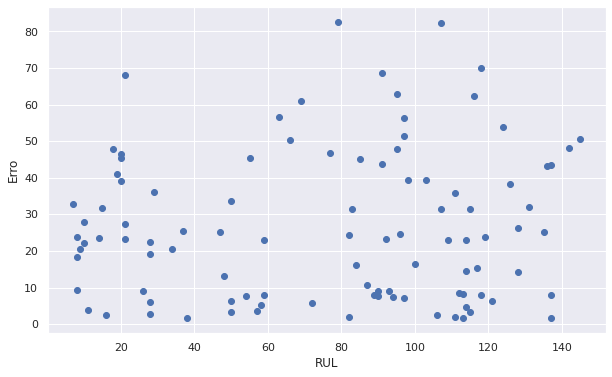

In [ ]:
y = get_values_motors(y_test['RUL'].values, True)
y_hat = get_values_motors(pd.DataFrame(predicts_svr, columns=['RUL'])['RUL'].values, True)

rt = pd.DataFrame({
    'y': y,
    'y_hat': y_hat
})
rt['error'] = np.sqrt((rt['y'] - rt['y_hat'])**2)

plt.figure(figsize=(10,6))
plt.scatter(rt['y'], rt['error'])
plt.xlabel("RUL")
plt.ylabel("Erro")
plt.grid(True)
plt.show()


####Histograma comparativo

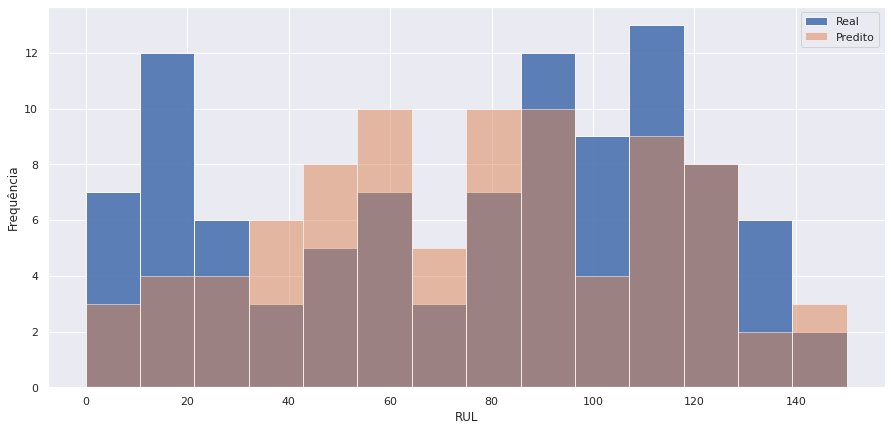

In [ ]:
bins = np.linspace(0, 150, 15)
plt.figure(figsize=(15,7)) 
plt.hist(rt['y'], bins, alpha=0.9, label='Real')
plt.hist(rt['y_hat'], bins, alpha=0.5, label='Predito')
plt.xlabel('RUL')
plt.ylabel('Frequência')
plt.legend()
plt.show()

##3 Comparação

###Boxplot

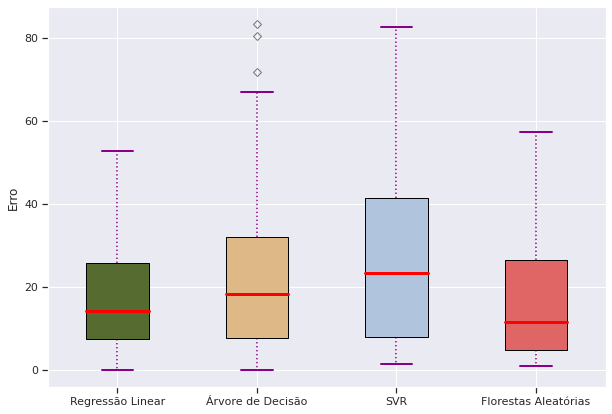

In [ ]:
y = get_values_motors(y_test['RUL'].values, True)
lin = get_values_motors(pd.DataFrame(predicts_lin_reg, columns=['RUL'])['RUL'].values, True)
tree = get_values_motors(pd.DataFrame(predicts_tree_reg, columns=['RUL'])['RUL'].values, True)
svr = get_values_motors(pd.DataFrame(predicts_svr, columns=['RUL'])['RUL'].values, True)
rfors = get_values_motors(pd.DataFrame(predicts_forest_reg_with_randomized_search, columns=['RUL'])['RUL'].values, True)

rt = pd.DataFrame({
    'y': y,
    'lin': lin,
    'tree': tree,
    'svr': svr,
    'rfors': rfors,
})

rt['lin_error'] = np.sqrt((rt['y'] - rt['lin'])**2)
rt['tree_error'] = np.sqrt((rt['y'] - rt['tree'])**2)
rt['svr_error'] = np.sqrt((rt['y'] - rt['svr'])**2)
rt['rfors_error'] = np.sqrt((rt['y'] - rt['rfors'])**2)

# Creating dataset
np.random.seed(10)

data_1 = rt['lin_error']
data_2 = rt['tree_error']
data_3 = rt['svr_error']
data_4 = rt['rfors_error']
data = [data_1, data_2, data_3, data_4]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

# Creating axes instance
bp = ax.boxplot(data, patch_artist = True, vert = 1)

colors = ['#556B2F', '#DEB887',
		'#B0C4DE', '#e06666']

for patch, color in zip(bp['boxes'], colors):
	patch.set_facecolor(color)

# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
	whisker.set(color ='#8B008B',
				linewidth = 1.5,
				linestyle =":")

# changing color and linewidth of
# caps
for cap in bp['caps']:
	cap.set(color ='#8B008B',
			linewidth = 2)

# changing color and linewidth of
# medians
for median in bp['medians']:
	median.set(color ='red',
			linewidth = 3)

# changing style of fliers
for flier in bp['fliers']:
	flier.set(marker ='D',
			color ='#e7298a',
			alpha = 0.5)
	
# x-axis labels
ax.set_xticklabels(['Regressão Linear', 'Árvore de Decisão',
					'SVR', 'Florestas Aleatórias'])

# Adding title
#plt.title("Customized box plot")

# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.ylabel('Erro')
	
# show plot
plt.show()


In [ ]:

y = get_values_motors(y_test['RUL'].values, True)
lin = get_values_motors(pd.DataFrame(predicts_lin_reg, columns=['RUL'])['RUL'].values, True)
tree = get_values_motors(pd.DataFrame(predicts_tree_reg, columns=['RUL'])['RUL'].values, True)
svr = get_values_motors(pd.DataFrame(predicts_svr, columns=['RUL'])['RUL'].values, True)
rfors = get_values_motors(pd.DataFrame(predicts_forest_reg_with_randomized_search, columns=['RUL'])['RUL'].values, True)

rt = pd.DataFrame({
    'y': y,
    'lin': lin,
    'tree': tree,
    'svr': svr,
    'rfors': rfors,
})

evaluate_rmse(rt["y"], rt['lin'], "lin")
evaluate_rmse(rt["y"], rt['tree'], "tree")
evaluate_rmse(rt["y"], rt['svr'], "svr")
evaluate_rmse(rt["y"], rt['rfors'], "rfo")

lin_rmse = rmse(rt['y'], rt['lin'])
tree_rmse = rmse(rt['y'], rt['tree'])
svr_rmse = rmse(rt['y'], rt['svr'])
rfo_rmse = rmse(rt['y'], rt['rfors'])

lin_r2 = r2(rt['y'], rt['lin'])
tree_r2 = r2(rt['y'], rt['tree'])
svr_r2 = r2(rt['y'], rt['svr'])
rfo_r2 = r2(rt['y'], rt['rfors'])



lin set RMSE:21.89088800244334, R2:0.7224972994280994
tree set RMSE:28.341302634944142, R2:0.5348638744665538
svr set RMSE:33.475258885395824, R2:0.3510842061008703
rfo set RMSE:21.08799179134511, R2:0.7424800356715766


###Discrepância

In [ ]:
def get_whiskers(arr1):
  q1 = np.quantile(arr1, 0.25)
  q3 = np.quantile(arr1, 0.75)
  med = np.median(arr1)
  iqr = q3-q1
  upper_bound = q3+(1.5*iqr)
  lower_bound = q1-(1.5*iqr)
  return {
      'upper_bound': upper_bound,
      'lower_bound': lower_bound,
  }

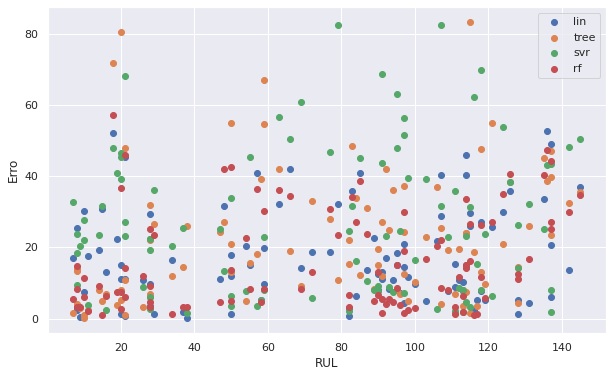

In [ ]:
y = get_values_motors(y_test['RUL'].values, True)
lin = get_values_motors(pd.DataFrame(predicts_lin_reg, columns=['RUL'])['RUL'].values, True)
tree = get_values_motors(pd.DataFrame(predicts_tree_reg, columns=['RUL'])['RUL'].values, True)
svr = get_values_motors(pd.DataFrame(predicts_svr, columns=['RUL'])['RUL'].values, True)
rfors = get_values_motors(pd.DataFrame(predicts_forest_reg_with_randomized_search, columns=['RUL'])['RUL'].values, True)

rt = pd.DataFrame({
    'y': y,
    'lin': lin,
    'tree': tree,
    'svr': svr,
    'rfors': rfors,
})

rt['lin_error'] = np.sqrt((rt['y'] - rt['lin'])**2)
rt['tree_error'] = np.sqrt((rt['y'] - rt['tree'])**2)
rt['svr_error'] = np.sqrt((rt['y'] - rt['svr'])**2)
rt['rfors_error'] = np.sqrt((rt['y'] - rt['rfors'])**2)

plt.figure(figsize=(10,6))
plt.scatter(rt['y'], rt['lin_error'], label='lin')
plt.scatter(rt['y'], rt['tree_error'], label='tree')
plt.scatter(rt['y'], rt['svr_error'], label='svr')
plt.scatter(rt['y'], rt['rfors_error'], label='rf')
plt.xlabel("RUL")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
rt.to_csv(dir_path + "discrepancia.csv", encoding = 'utf-8')

####Linha 40 RUL 18

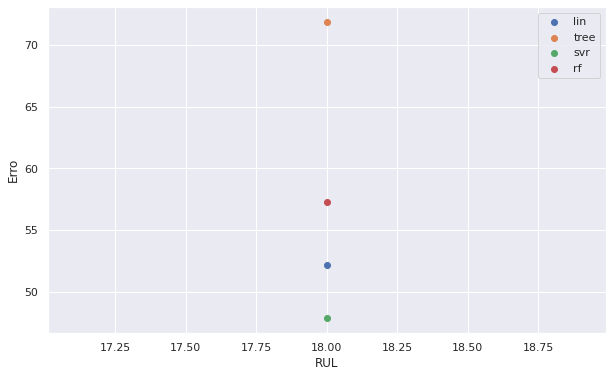

In [ ]:
y = get_values_motors(y_test['RUL'].values, True)
lin = get_values_motors(pd.DataFrame(predicts_lin_reg, columns=['RUL'])['RUL'].values, True)
tree = get_values_motors(pd.DataFrame(predicts_tree_reg, columns=['RUL'])['RUL'].values, True)
svr = get_values_motors(pd.DataFrame(predicts_svr, columns=['RUL'])['RUL'].values, True)
rfors = get_values_motors(pd.DataFrame(predicts_forest_reg_with_randomized_search, columns=['RUL'])['RUL'].values, True)

rt = pd.DataFrame({
    'y': y,
    'lin': lin,
    'tree': tree,
    'svr': svr,
    'rfors': rfors,
})

rt['lin_error'] = np.sqrt((rt['y'] - rt['lin'])**2)
rt['tree_error'] = np.sqrt((rt['y'] - rt['tree'])**2)
rt['svr_error'] = np.sqrt((rt['y'] - rt['svr'])**2)
rt['rfors_error'] = np.sqrt((rt['y'] - rt['rfors'])**2)

plt.figure(figsize=(10,6))
plt.scatter(rt['y'][40], rt['lin_error'][40], label='lin')
plt.scatter(rt['y'][40], rt['tree_error'][40], label='tree')
plt.scatter(rt['y'][40], rt['svr_error'][40], label='svr')
plt.scatter(rt['y'][40], rt['rfors_error'][40], label='rf')
plt.xlabel("RUL")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.show()


#### Linha 23 RUL 20

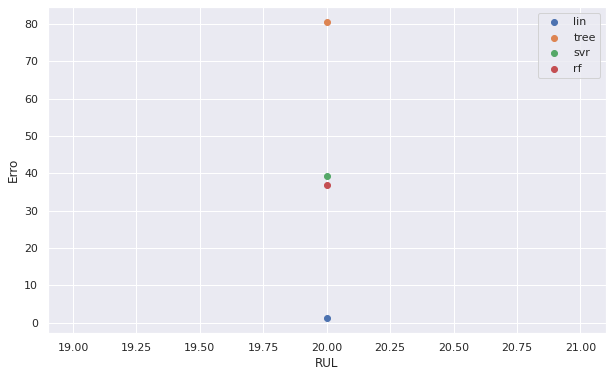

In [ ]:
y = get_values_motors(y_test['RUL'].values, True)
lin = get_values_motors(pd.DataFrame(predicts_lin_reg, columns=['RUL'])['RUL'].values, True)
tree = get_values_motors(pd.DataFrame(predicts_tree_reg, columns=['RUL'])['RUL'].values, True)
svr = get_values_motors(pd.DataFrame(predicts_svr, columns=['RUL'])['RUL'].values, True)
rfors = get_values_motors(pd.DataFrame(predicts_forest_reg_with_randomized_search, columns=['RUL'])['RUL'].values, True)

rt = pd.DataFrame({
    'y': y,
    'lin': lin,
    'tree': tree,
    'svr': svr,
    'rfors': rfors,
})

rt['lin_error'] = np.sqrt((rt['y'] - rt['lin'])**2)
rt['tree_error'] = np.sqrt((rt['y'] - rt['tree'])**2)
rt['svr_error'] = np.sqrt((rt['y'] - rt['svr'])**2)
rt['rfors_error'] = np.sqrt((rt['y'] - rt['rfors'])**2)

plt.figure(figsize=(10,6))
plt.scatter(rt['y'][23], rt['lin_error'][23], label='lin')
plt.scatter(rt['y'][23], rt['tree_error'][23], label='tree')
plt.scatter(rt['y'][23], rt['svr_error'][23], label='svr')
plt.scatter(rt['y'][23], rt['rfors_error'][23], label='rf')
plt.xlabel("RUL")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.show()


####Linha 42 RUL 59

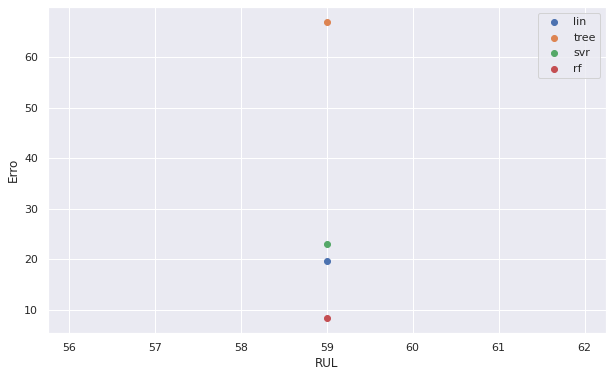

In [ ]:
y = get_values_motors(y_test['RUL'].values, True)
lin = get_values_motors(pd.DataFrame(predicts_lin_reg, columns=['RUL'])['RUL'].values, True)
tree = get_values_motors(pd.DataFrame(predicts_tree_reg, columns=['RUL'])['RUL'].values, True)
svr = get_values_motors(pd.DataFrame(predicts_svr, columns=['RUL'])['RUL'].values, True)
rfors = get_values_motors(pd.DataFrame(predicts_forest_reg_with_randomized_search, columns=['RUL'])['RUL'].values, True)

rt = pd.DataFrame({
    'y': y,
    'lin': lin,
    'tree': tree,
    'svr': svr,
    'rfors': rfors,
})

rt['lin_error'] = np.sqrt((rt['y'] - rt['lin'])**2)
rt['tree_error'] = np.sqrt((rt['y'] - rt['tree'])**2)
rt['svr_error'] = np.sqrt((rt['y'] - rt['svr'])**2)
rt['rfors_error'] = np.sqrt((rt['y'] - rt['rfors'])**2)

plt.figure(figsize=(10,6))
plt.scatter(rt['y'][42], rt['lin_error'][42], label='lin')
plt.scatter(rt['y'][42], rt['tree_error'][42], label='tree')
plt.scatter(rt['y'][42], rt['svr_error'][42], label='svr')
plt.scatter(rt['y'][42], rt['rfors_error'][42], label='rf')
plt.xlabel("RUL")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.show()
